In [1]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

In [2]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [8]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.6.0+cpu
2.6.0+cpu


In [3]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")

                file_path = os.path.join(actor_path, file)

                data.append({"emotion": emotion, "file_path": file_path})

df = pd.DataFrame(data)

print(df)

        emotion                                          file_path
0       neutral  data/ravdess-emotional-speech-audio/versions/1...
1       neutral  data/ravdess-emotional-speech-audio/versions/1...
2       neutral  data/ravdess-emotional-speech-audio/versions/1...
3       neutral  data/ravdess-emotional-speech-audio/versions/1...
4          calm  data/ravdess-emotional-speech-audio/versions/1...
...         ...                                                ...
1435  surprised  data/ravdess-emotional-speech-audio/versions/1...
1436  surprised  data/ravdess-emotional-speech-audio/versions/1...
1437  surprised  data/ravdess-emotional-speech-audio/versions/1...
1438  surprised  data/ravdess-emotional-speech-audio/versions/1...
1439  surprised  data/ravdess-emotional-speech-audio/versions/1...

[1440 rows x 2 columns]


In [24]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(42)

SAMPLE_SPEECH = "data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-02-01-01.wav"


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [25]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

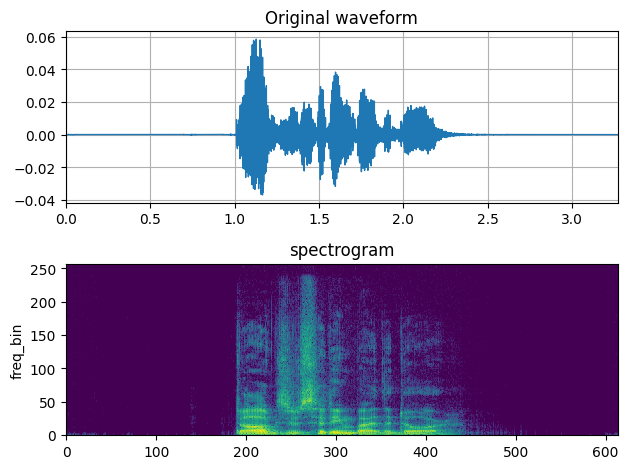

In [26]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout() 

In [20]:
import numpy as np

spec.numpy()

array([[[4.7109430e-07, 1.5978516e-08, 1.6689436e-08, ...,
         6.5189234e-08, 2.3239276e-10, 5.7147256e-09],
        [3.6597396e-07, 2.3185489e-08, 1.8326007e-09, ...,
         4.4792458e-08, 2.2967205e-10, 3.5728058e-09],
        [1.5825766e-07, 5.4589298e-09, 4.6300253e-09, ...,
         1.3429641e-08, 2.2164212e-10, 4.9354287e-10],
        ...,
        [3.5559549e-09, 7.9099109e-09, 3.0818614e-09, ...,
         6.1727663e-09, 2.2164212e-10, 5.2762203e-09],
        [6.4059613e-10, 6.5886883e-09, 4.1964414e-09, ...,
         2.0783336e-08, 2.2967205e-10, 2.3467184e-09],
        [9.4025385e-11, 7.9869098e-09, 5.1885642e-09, ...,
         3.1813833e-08, 2.3239276e-10, 2.5554064e-10]]], dtype=float32)